In [1]:
# Importing libraries and modules
import Pkg; Pkg.activate("..")
using Pkg; Pkg.instantiate()
include("ElemSDEUtils.jl")
using .ElemSDEutils, Plots, Statistics, Distributions, KernelDensity, StatsBase

  Activating project at `~/Documents/Bachelor Thesis Stuff`
  Activating project at `~/Documents/Bachelor Thesis Stuff/bachelorsthesis`


### Biochemical Reaction Kinetics

$$ 
\begin{align}
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{more Biomass X}, \\
    \text{Substrate S} &\xrightarrow{\text{Biomass X}} \text{Product Y}, \\
    \text{Product Y} &\xrightarrow{\text{Biomass X}} \text{Byproduct Z}.
\end{align}
$$

In [20]:
# Setting up the model parameters
# The parameters are defined in a dictionary for easy access and modification
params = Dict(
    "k1" => 0.5,  # Rate constant for X
    "k2" => 0.5,  # Rate constant for Y
    "σ" => 0.25,    # Noise scaling parameter
    "K_sy" => 0.25  # Saturation constant for Y
)

# Initial conditions for the state variables
# The initial conditions are defined in a dictionary for easy access and modification
init = Dict(
    "X0" => 10.0, 
    "Y0" => 0.0, 
    "Z0" => 0.0
)

# Time parameters
T = 25.0  # Time span for the simulation
dt = 0.01  # Time step for the simulation
tsteps = 0:dt:T  # Time steps array
N = length(tsteps)  # Number of time steps

# Running the Monte Carlo simulation
M = 1_000  # Number of Monte Carlo simulations
noise = "noise" # Type of noise for the SDEs ("noise" or "monod")
sdesol = simulate_paths(params, T, init, M, noise, dt)[1]
odesol = simulate_paths(params, T, init, M, noise, dt)[2]
time = odesol.t  # Time vector from the ODE solution

# Storing the results in matrices for each state variable
X = zeros(length(sdesol), length(sdesol[1].t))
Y = zeros(length(sdesol), length(sdesol[1].t))
Z = zeros(length(sdesol), length(sdesol[1].t))

for i in 1:length(sdesol)
    X[i, :] = sdesol[i][1, :]
    Y[i, :] = sdesol[i][2, :]
    Z[i, :] = sdesol[i][3, :]
end

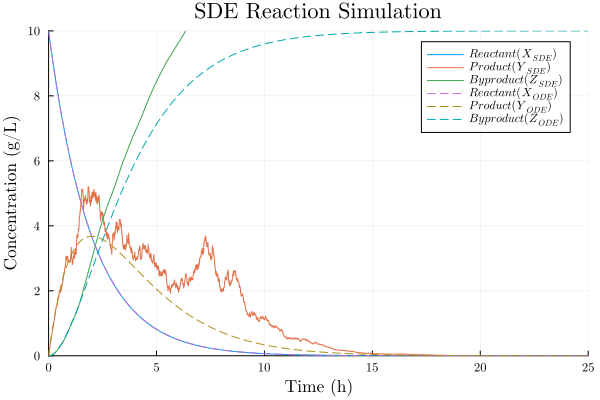

In [21]:
# Plotting the results
using LaTeXStrings
plot(sdesol[50], title="SDE Reaction Simulation", label=[L"Reactant (X_{SDE})" L"Product (Y_{SDE})" L"Byproduct (Z_{SDE})"], xlabel="Time (h)", ylabel="Concentration (g/L)")
plot!(odesol, title="SDE Reaction Simulation", label=[L"Reactant (X_{ODE})" L"Product (Y_{ODE})" L"Byproduct (Z_{ODE})"], xlabel="Time (h)", ylabel="Concentration (g/L)", lines=:dash)
plot!(legend=:topright, fontfamily="Computer Modern", lw=2, markersize=4, grid=true, ylims=(0, init["X0"]), xlims=(0, T))

### Longstaff-Schwartz Algorithm

In [22]:
# Store stopping times
τ = fill(length(tsteps), M)

# Initialize matrices for Longstaff-Schwartz
V = copy(Y) # copy(Xs) if we're using Xs
degree = 3  # Degree of polynomial basis
β_matrix = zeros(N, degree + 1)

# Longstaff-Schwartz backward induction in time
for n in (length(tsteps)-1):-1:2
    y_now = Y[:, n]
    value_future = V[:, n+1]

    # Optional: Filter out non-positive values (in-the-money paths for options)
    # all of the values are supposed to be positive
    itm_indices = findall(y -> y > 0, y_now)
    if length(itm_indices) < 10
        continue
    end

    y_itm = y_now[itm_indices]
    vf_itm = value_future[itm_indices]

    # Fit polynomial regression using Laguerre basis functions
    Φ = laguerre_design_matrix(y_itm, degree)
    β = Φ \ vf_itm
    
    # Compute continuation value
    # Note: This is where the polynomial regression is used to compute the continuation value
    continuation_value = Φ * β
    stop_now = y_itm .> continuation_value

    # Update stopping times
    # Note: This is where we update the stopping times based on the stopping condition
    for (idx, stop) in zip(itm_indices, stop_now)
        if stop
            V[idx,n] = y_now[idx]
            τ[idx] = min(τ[idx], n)
        else
            V[idx,n] = V[idx,n+1]
        end
    end

    # Save regression coefficients
    β_matrix[n, :] .= β

end

# Compile and plot outputs
Y_opt_values = [Y[i, τ[i]] for i in 1:M]
τ_times = [tsteps[τ[i]] for i in 1:M]

1000-element Vector{Float64}:
 5.77
 7.25
 8.6
 5.12
 4.4
 6.47
 6.08
 5.12
 7.44
 8.22
 ⋮
 6.87
 6.08
 4.12
 5.93
 4.97
 3.44
 3.89
 5.59
 7.97

### Results

Estimated optimal expected value of Y: 3.7507 g/L
Expected optimal stopping time: 6.0624 h
95% confidence interval for stopping time: 3.8598 to 8.43 h
95% confidence interval for expected value of Y: 2.206 to 4.8374


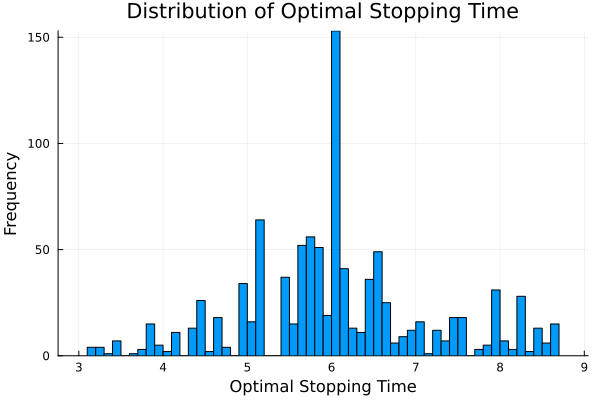

In [23]:
# Plotting the results
println("Estimated optimal expected value of Y: ", round(mean(Y_opt_values), digits=4), " g/L")
println("Expected optimal stopping time: ", round(mean(τ_times), digits=4), " h")
println("95% confidence interval for stopping time: ", round(quantile(τ_times, 0.025), digits=4), " to ", round(quantile(τ_times, 0.975), digits=4), " h")
println("95% confidence interval for expected value of Y: ", round(quantile(Y_opt_values, 0.025), digits=4), " to ", round(quantile(Y_opt_values, 0.975), digits=4))
histogram(τ_times, bins=50, title="Distribution of Optimal Stopping Times", xlabel="Optimal Stopping Time", ylabel="Frequency", legend=false)
plot!(xlabel="Optimal Stopping Time", ylabel="Frequency", title="Distribution of Optimal Stopping Time", legend=false, grid=true)